In [10]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import time
import pandas as pd

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
import qiskit

In [11]:
def draw_graph(G, colors, pos):
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def graph_generation(dim):
    # Generating the system
    N = dim
    G1 = nx.grid_2d_graph(N,N)
    pos = dict( (n, n) for n in G1.nodes() )
    labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )
    # Transform to weighted graph:
    n = N**2
    V = np.arange(0, N, 1)

    E =[]

    tuples = []
    other_tup = []
    point_edge_map = []
    other_map = []
    relations = []

    for edge in G1.edges:
        point1 = edge[0]
        strpoint1 = str(point1[0]) + str(point1[1])
        point2 = edge[1]
        strpoint2 = str(point2[0]) + str(point2[1])
        if not strpoint1 in point_edge_map:
            point_edge_map.append(strpoint1)
            tuples.append(edge[0])
        if not strpoint2 in other_map:
            other_map.append(strpoint2)
            other_tup.append(edge[1])
        relations.append((strpoint1, strpoint2))

    tuples.append(other_tup[len(other_tup) - 1])
    point_edge_map.append(other_map[len(other_map) - 1])

    dic = {}
    for i in range(len(point_edge_map)):
        dic[i] = point_edge_map[i]

    point_edge_map = np.array(point_edge_map)
    relations = np.array(relations)

    for relation in relations:
        ver1 = relation[0]
        ver2 = relation[1]
        point1 = np.where(point_edge_map == ver1)[0][0]
        point2 = np.where(point_edge_map == ver2)[0][0]
        edge = (point1, point2, 1.0)
        E.append(edge)

    G = nx.Graph()

    G.add_nodes_from(V)

    G.add_weighted_edges_from(E)

    colors = ["b" for node in G.nodes()]
    pos = dict()
    for i in range(n):
        pos[i] = tuples[i]


    draw_graph(G, colors, pos)
    
    # Matrix Representation of Graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
                
    return G, w, pos

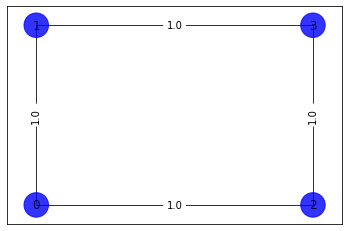

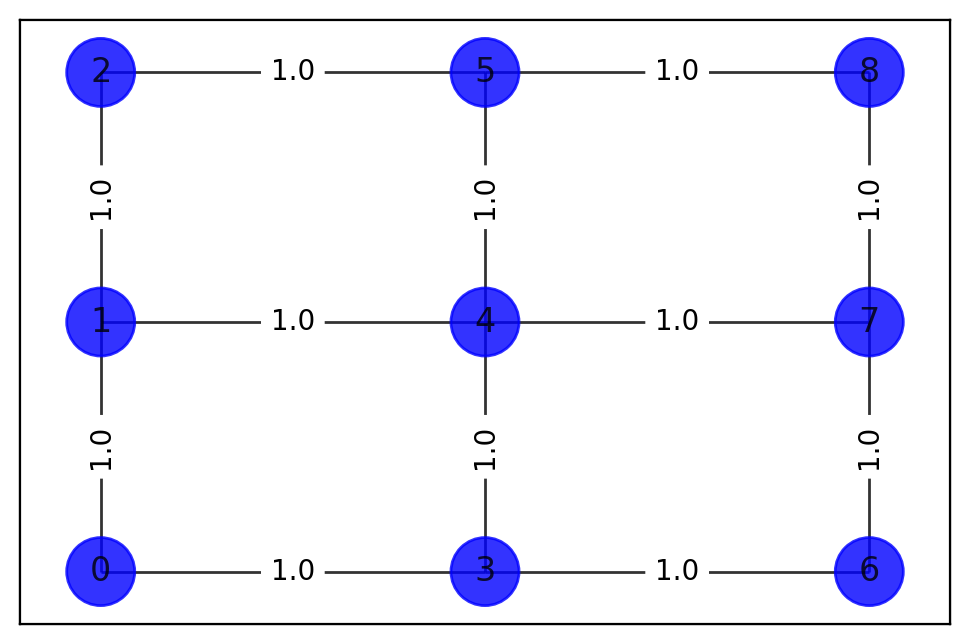

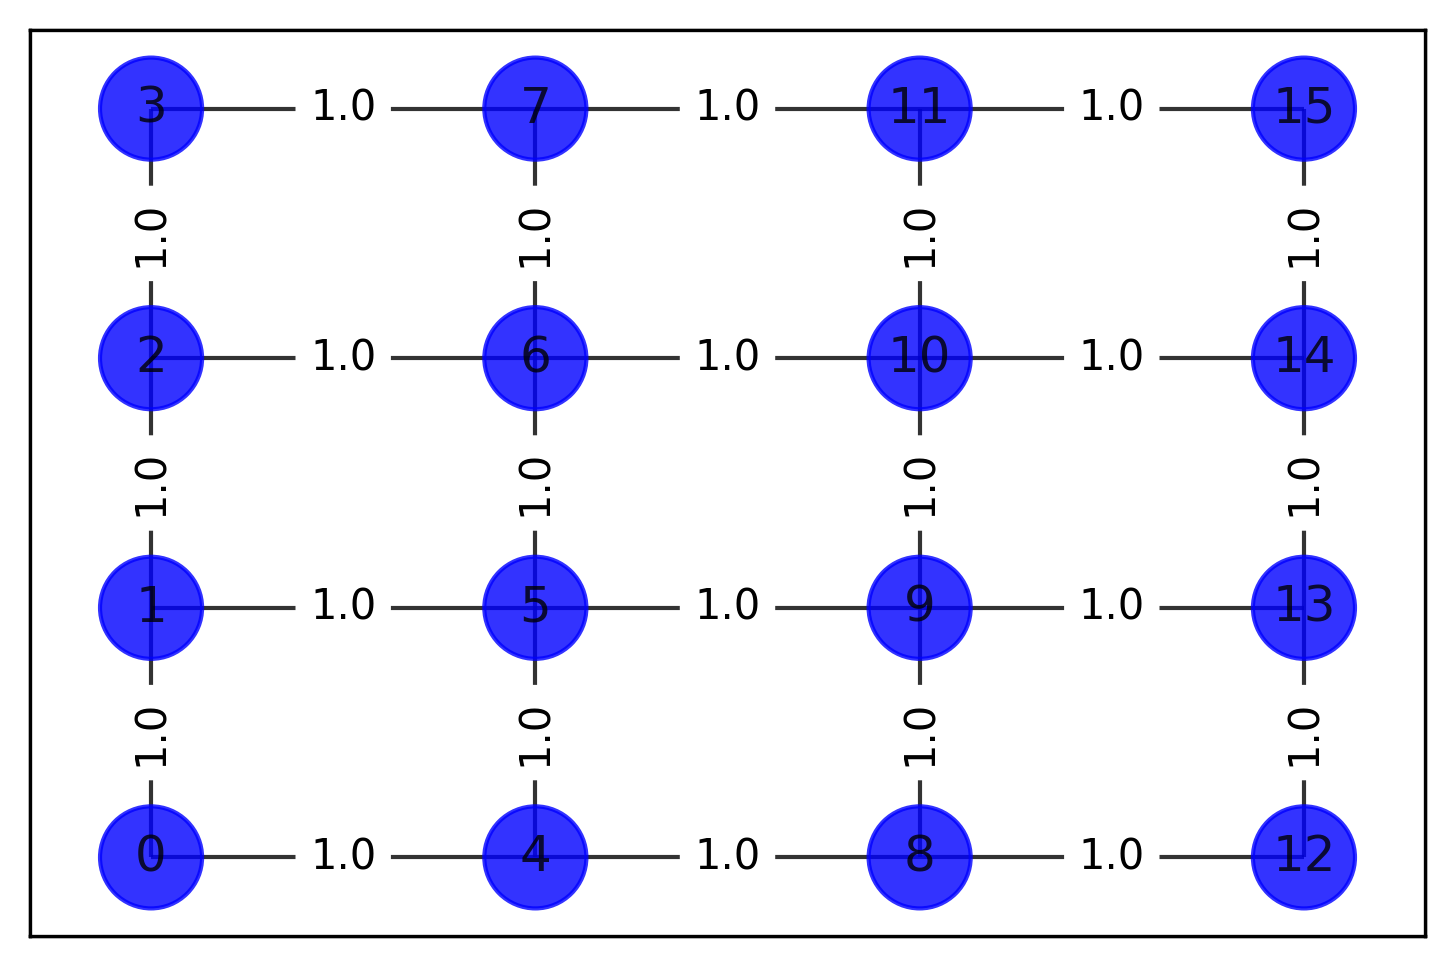

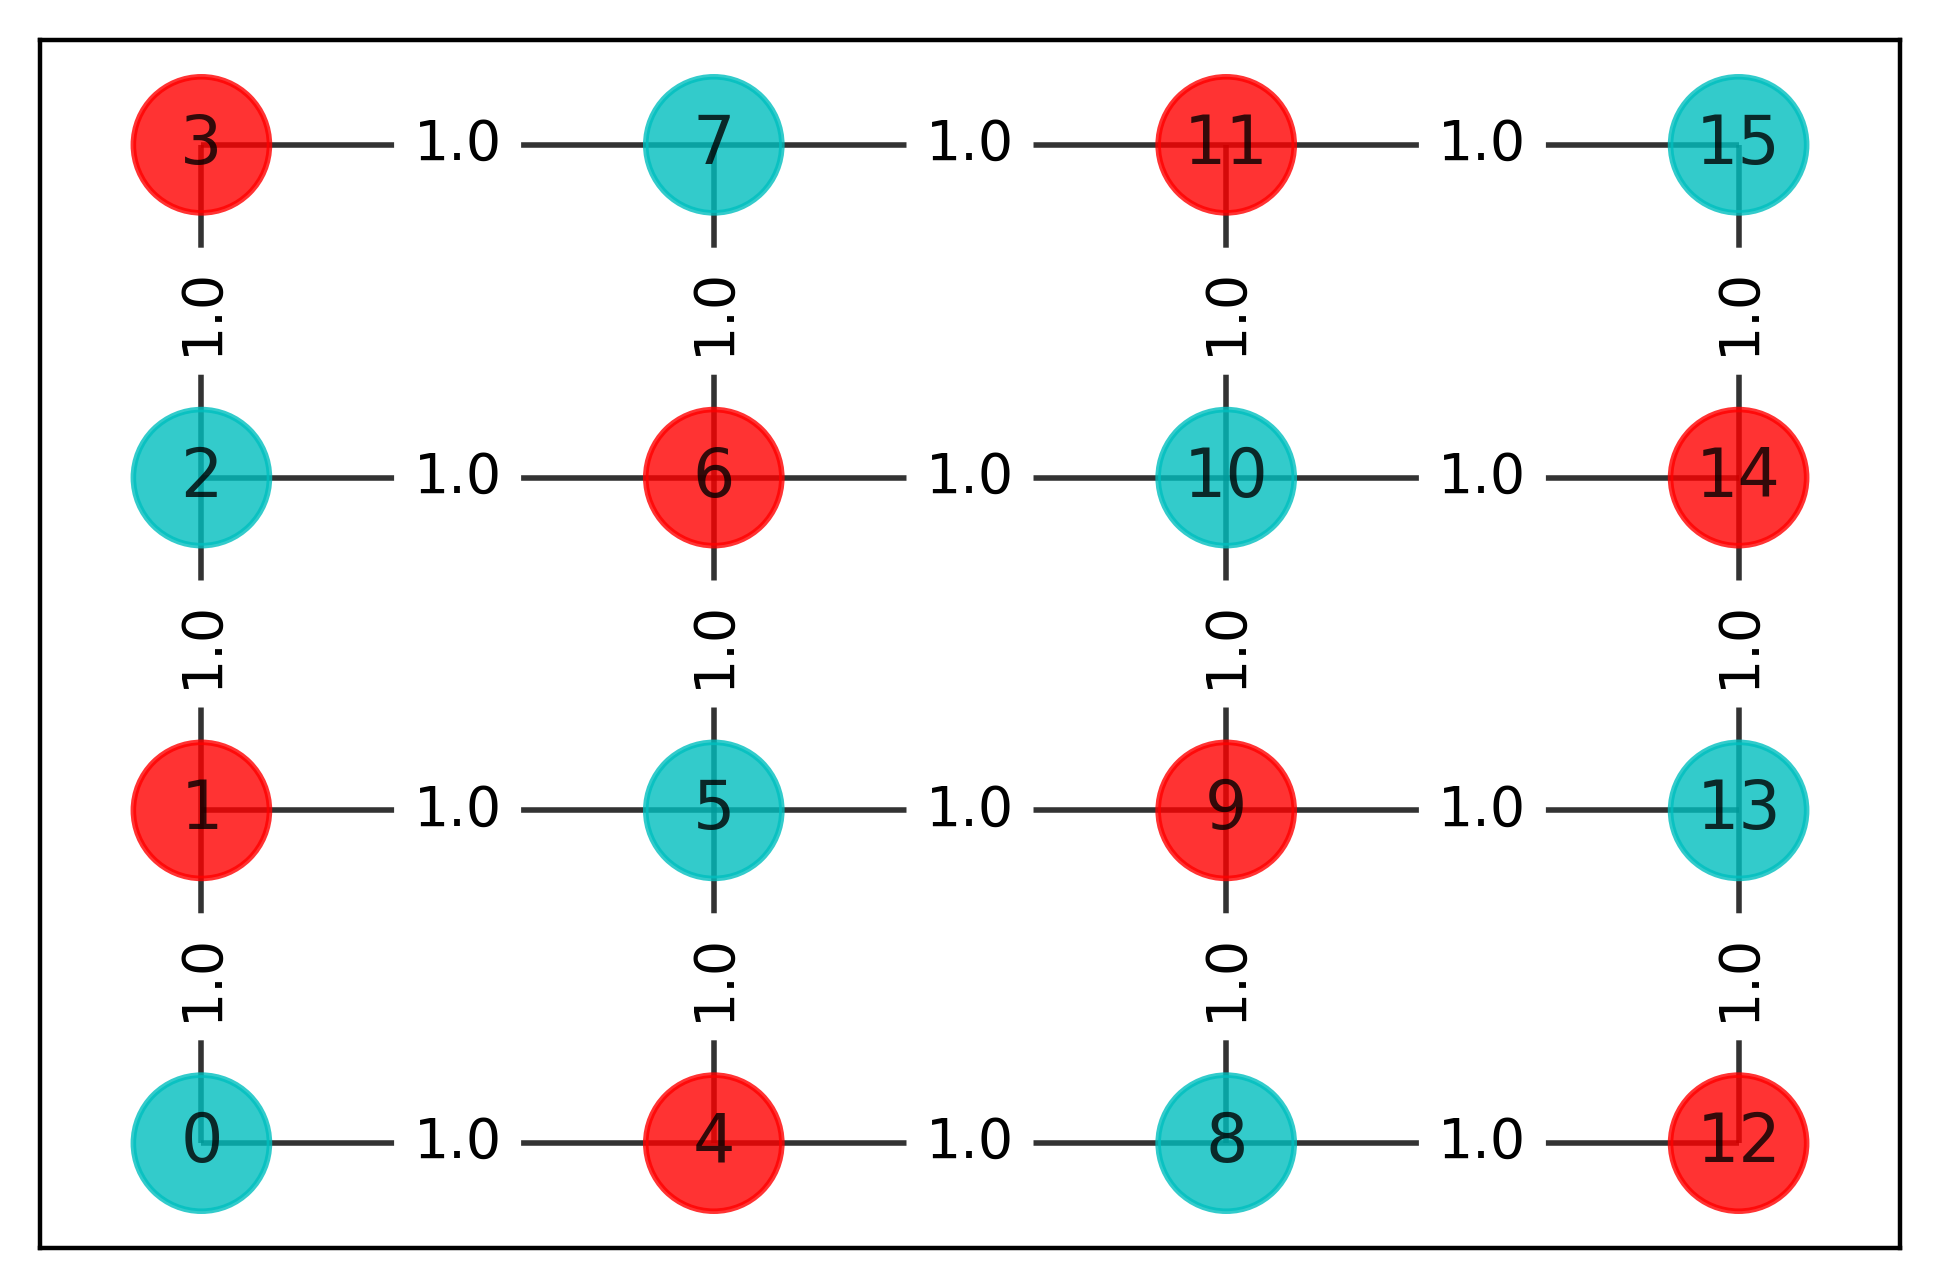

In [12]:
algorithm_globals.massive=True

data = pd.DataFrame()

algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
dimention = []
energy = []
time = []
max_cum_objective = []
solution = []
solution_objective = []
figs = []

for i in range(2, 5):
    G, w, pos = graph_generation(i)
    max_cut = Maxcut(w)
    qp = max_cut.to_quadratic_program()
    qubitOp, offset = qp.to_ising()
    exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
    # construct VQE
    cobyla = COBYLA(maxiter=300)
    ry = TwoLocal(qubitOp.num_qubits, "ry", reps=0, entanglement="linear")
    vqe = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)

    # run VQE
    result = vqe.compute_minimum_eigenvalue(qubitOp)
    x = max_cut.sample_most_likely(result.eigenstate)
    dimention.append(i)
    energy.append(result.eigenvalue.real)
    time.append(result.optimizer_time)
    max_cum_objective.append(result.eigenvalue.real + offset)
    solution.append(max_cut.sample_most_likely(result.eigenstate))
    solution_objective.append(qp.objective.evaluate(x))
    
    # plot results
    fig = plt.figure(dpi = i * 100)
    colors = ["r" if x[j] == 0 else "c" for j in range(i*i)]
    draw_graph(G, colors, pos)
    plt.savefig(r"/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/Benchmarking/Dimentions/" + "dim" + str(i))
    figs.append(fig)
data['dimention'] = dimention
data['optimizer'] = np.full(3, "COBYLA(maxiter=300)")
data['energy'] = energy
data['time (s)'] = time
data['max cum objective'] = max_cum_objective
data['solution'] = solution
data['solution objective'] = solution_objective
data['figure'] = figs
data.to_excel(r'/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/Benchmarking/Dimentions/data.xlsx')